# Resolution Calculation using Covariance Matrix - pick E,q pairs

Instrument: ARCS
* Ei=60
* Fermi chopper: 600 Hz
* T0: 120Hz

In [1]:
# some goodies
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import mcvine.cli
from mcvine_workflow.DGS import ARCS

In [2]:
import histogram.hdf as hh, histogram as H

In [3]:
workdir = '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/debug-Ricky/'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/debug-Ricky


## Inputs

### ARCS parameters

In [4]:
L_PM=11.61
R = 3.
L_PS=13.6
L_MS=L_PS-L_PM

In [5]:
print L_MS

1.99


### Sample

In [6]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 5.490700041, 5.490700041, 5.490700041, 90, 90, 90
 basis_vectors:
  - 5.490700041, 0, 0
  - 0, 5.490700041, 0
  - 0, 0, 5.490700041
 primitive_basis_vectors:
  - 0.0, 2.71526503565, 2.71526503565
  - 2.71526503565, 0.0, 2.71526503565
  - 2.71526503565, 2.71526503565, 0.0
excitations:
  - type: deltafunction
    hkl: -16/3.,-8/3.,8/3.
    E: 40.
    dE: 0.5
orientation:
 u: -1, 1, -1
 v: 2, 1, -1
shape: hollowCylinder in_radius="5./8*inch" out_radius="1.*inch" height="1.5*inch"
temperature: 100*K

Overwriting Si.yml


In [7]:
sample_yml = './Si.yml'

### ** Dynamics parameters

In [8]:
Ei = 60

In [9]:
hkl0 = np.array([0.,-0.,0.])
hkl_dir = np.array([1,0,0]) # projection

### ** Other parameters

In [10]:
# scan
psimin = -5
psimax = 90.
dpsi = 1.

### Dynamic range
Use the following code to explore the dynamic range

In [11]:
from mcvine_workflow.singlextal import dynrange
from mcvine_workflow.sample import loadSampleYml
sample = loadSampleYml(sample_yml)
psilist = np.arange(psimin, psimax, 5*dpsi)
qaxis = np.arange(-100, 100, .02)

(-59.948988723689666, 59.993865112464576)

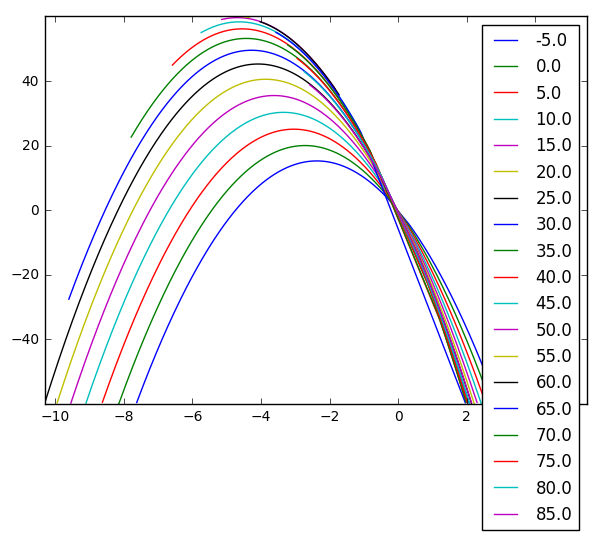

In [12]:
plt.figure(figsize=(7,5))
points_in_slice = list(dynrange.iterPointsInSlice(
        sample, psilist, Ei, hkl0, hkl_dir, qaxis,
        ARCS.scattering_angle_constraints,
        Erange=(-Ei, Ei)))
all_qs = np.concatenate([qs for _p, qs, _E in points_in_slice ])
qmin = np.min(all_qs); qmax = np.max(all_qs)

all_Es = np.concatenate([Es for _p, _q, Es in points_in_slice ])
Emin = np.min(all_Es); Emax = np.max(all_Es)

for psi, qs, Es in points_in_slice:
    plt.plot(qs, Es, label=str(psi))
    continue
    
plt.legend()
plt.xlim(qmin, qmax+(qmax-qmin)/5)
plt.ylim(Emin, Emax)

In [13]:
psilist = np.arange(psimin, psimax, dpsi)
points_in_slice = list(dynrange.iterPointsInSlice(
        sample, psilist, Ei, hkl0, hkl_dir, qaxis,
        ARCS.scattering_angle_constraints,
        Erange=(-Ei, Ei)))
all_qs = np.concatenate([qs for _p, qs, _E in points_in_slice ])
qmin = np.min(all_qs); qmax = np.max(all_qs)

all_Es = np.concatenate([Es for _p, _q, Es in points_in_slice ])
Emin = np.min(all_Es); Emax = np.max(all_Es)

In [14]:
fractions = [.9, .5, .25, 1./8, 1./16, 1./32, 1./64, 1./128]
Eq_pairs = []
for f in fractions:
    E = f*Ei
    print 'E=', E
    # find maximum Es smaller than E
    max_Es_smaller = np.max(all_Es[all_Es<E])
    # find minimum Es greater than E
    min_Es_greater = np.min(all_Es[all_Es>E])
    # print E, max_Es_smaller, min_Es_greater
    Ebracket = min(max_Es_smaller, E*.99), max(min_Es_greater, E*1.01)
    # get qs
    qs = all_qs[ (all_Es>=Ebracket[0])*(all_Es<=Ebracket[1]) ]
    # print len(qs)
    while len(qs) < 10:
        Ebracket = Ebracket[0]*.95, Ebracket[1]*1.05
        qs = all_qs[ (all_Es>=Ebracket[0])*(all_Es<=Ebracket[1]) ]
    print "Ebracket=", Ebracket, 'number of qs=', len(qs)
    Eq_pairs.append( (E, np.mean(qs)))
Eq_pairs = np.array(Eq_pairs)

E= 54.0
Ebracket= (53.46, 54.54) number of qs= 389
E= 30.0
Ebracket= (29.7, 30.3) number of qs= 279
E= 15.0
Ebracket= (14.85, 15.15) number of qs= 134
E= 7.5
Ebracket= (7.425, 7.575) number of qs= 28
E= 3.75
Ebracket= (3.7125, 3.7875) number of qs= 10
E= 1.875
Ebracket= (1.7634374999999998, 1.9884375) number of qs= 29
E= 0.9375
Ebracket= (0.80414211662367208, 1.0439296875000001) number of qs= 22
E= 0.46875
Ebracket= (0.42488057586066041, 0.52413770618242383) number of qs= 13


In [15]:
print Ei
print Eq_pairs

60
[[ 54.          -4.09588689]
 [ 30.          -3.17390681]
 [ 15.          -2.75686567]
 [  7.5         -4.13928571]
 [  3.75        -5.208     ]
 [  1.875       -6.66758621]
 [  0.9375      -6.80363636]
 [  0.46875     -6.71384615]]
